In [2]:
import random
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from src.lfgp import LFGP
from collections import defaultdict
from scipy.optimize import linear_sum_assignment

In [3]:
# Shadow prices
B = 50000    # Buffer size
zeta = 5    # Factor for derivative term
W = 2400    # Window size for the moving average
num_epochs = 200  # Total number of epochs to simulate

# Initialize queue lengths for each epoch (randomly for the sake of simulation)
np.random.seed(42)  # Seed for reproducibility
queue_lengths = np.random.randint(0, B, num_epochs)

# Initialize prices and moving averages
prices = np.zeros(num_epochs)
moving_averages = np.zeros(num_epochs)

# Simulation of the PD-controlled pricing mechanism
for l in range(1, num_epochs):
    # Compute the moving average of the queue length
    if l < W:
        moving_averages[l] = np.mean(queue_lengths[:l])
    else:
        moving_averages[l] = (1 - 1/W) * moving_averages[l-1] + (1/W) * queue_lengths[l]
    
    # Proportional term
    p_proportional = (B - queue_lengths[l]) / B
    
    # Derivative term
    p_derivative = -zeta * (queue_lengths[l] - moving_averages[l]) / B
    
    # Combine terms for total price and ensure it's not negative
    prices[l] = max(0, p_proportional + p_derivative)

In [4]:
def update_worker_latent_factors(worker_histories, worker_latent_factors):
    new_worker_latent_factors = np.zeros_like(worker_latent_factors)  # Initialize the new worker potential factor vector store

    for i, histories in enumerate(worker_histories.values()):  
        weighted_sum = np.zeros(worker_latent_factors.shape[1])
        total_weight = 0

        for j, (vector, performance) in enumerate(histories):  
            price = prices[j] 
            weight = 1 + price  # The greater the difficulty, the higher the weight
            weighted_sum += weight * np.array(vector) * performance
            total_weight += weight 

        # Update each worker's potential factor vector based on total_weight
        if total_weight > 0:
            new_worker_latent_factors[i] = weighted_sum / total_weight
        else:
            new_worker_latent_factors[i] = worker_latent_factors[i]  # If there is no valid history, the original value is left unchanged

    arr = np.array(new_worker_latent_factors)
    max_values = arr.max(axis=1, keepdims=True)  # Find the max values for each row/vector
    new_worker_latent_factors = np.where((arr > 0) & (arr == max_values), 1, arr)

    return new_worker_latent_factors

In [5]:
# Identify high-quality worker groups in each job group
def identify_high_quality_worker_groups(jobs_group_info, workers_group_info):
    # Build a mapping from job groups to worker groups
    job_to_workers_groups = defaultdict(lambda: defaultdict(int))
    
    for job_group, worker_group in zip(jobs_group_info, workers_group_info):
        job_to_workers_groups[job_group][worker_group] += 1
    
    high_quality_groups_for_jobs = {}
    
    for job_group, workers_groups in job_to_workers_groups.items():
        # Identify the worker group with the highest count in each job group as the high-quality group
        high_quality_group = max(workers_groups, key=workers_groups.get)
        high_quality_groups_for_jobs[job_group] = high_quality_group
    
    return high_quality_groups_for_jobs

In [6]:
def workers_jobs_group(total_workers_list, total_jobs_list):
    # Initialize LFGP model instance
    model = LFGP(lf_dim=6, n_worker_group=2, lambda1=1, lambda2=1)

    # Here we need to extract the latent factor vectors from workers_df and jobs_df, and convert them into a format suitable for the LFGP model
    workers_lf = np.array([attributes for _, attributes in total_workers_list])
    jobs_lf = np.array([attributes for _, attributes in total_jobs_list])

    # Directly set the model's worker and job latent factor vectors, as well as the corresponding group information
    model.A = jobs_lf  # Assume A represents the latent factors of jobs
    model.B = workers_lf  # Assume B represents the latent factors of workers

    # Assume each worker and job is randomly assigned to a group
    np.random.seed(42)
    model.U = np.random.randint(0, 2, size=(len(total_workers_list),))  # Job grouping
    model.V = np.random.randint(0, 2, size=(len(total_workers_list),))  # Worker grouping

    # Hypothetical group information for jobs and workers
    jobs_group_info = np.array(model.U)
    workers_group_info = np.array(model.V)

    # Execute the function to get the high-quality worker group for each job group
    high_quality_groups = identify_high_quality_worker_groups(jobs_group_info, workers_group_info)

    return(high_quality_groups, jobs_group_info, workers_group_info)

In [7]:
def perform_matching(high_quality_groups, jobs_group_info, workers_group_info, worker_histories, total_workers_list, total_jobs_list):
    matched_jobs = {}
    matched_jobs_set = set()  
    matched_workers_set = set()  

    for job_group, worker_group in high_quality_groups.items():
        jobs_in_group = [job_index for job_index, group in enumerate(jobs_group_info) if group == job_group]
        np.random.shuffle(jobs_in_group)
        
        workers_in_group = [worker_index for worker_index, group in enumerate(workers_group_info) if group == worker_group]
        
        # Each worker is randomly matched to a job
        for worker_index in workers_in_group:
            if len(jobs_in_group) == 0:
                break
            job_index = jobs_in_group.pop(0)  # Remove and get the first job in the list
            matched_jobs[worker_index] = job_index
            matched_jobs_set.add(job_index)  # Add to the matched job collection
            matched_workers_set.add(worker_index)  # Add to the matched worker collection

    return worker_histories, matched_jobs_set, matched_workers_set

In [10]:
total_workers_list = []
total_jobs_list = []
worker_histories = defaultdict(list)

PR = []


workers_type = [(1, 1, 0), (1, 0, 1), (0, 0, 1), (0, 1, 0)]
jobs_type = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]

all_capabilities = workers_type * 600  

random.shuffle(all_capabilities)

for i in range(2400):
    capability_vector = all_capabilities[i]
    total_workers_list.append((f"worker {i + 1}", capability_vector))


for i in range(200):
    count1 = random.randint(1, 2398)  
    count2 = random.randint(1, 2399 - count1)  
    count3 = 2400 - count1 - count2  

    counts = [count1, count2, count3]
    all_factors = []
    for job, count in zip(jobs_type, counts):
        all_factors.extend([job] * count)

    random.shuffle(all_factors)

    for i in range(2400):
        factor_vector = all_factors[i]
        total_jobs_list.append((f"job {i + 1}", factor_vector))

    selected_jobs = random.sample(total_jobs_list, len(total_workers_list))

    if i == 0:
        total_profit = min(600, count1 + count2) + min(600, count1 + count3) + min(600, count3) + min(600, count2)

        sum_performance = 0

        for worker, job in zip(total_workers_list, selected_jobs):
            worker_name, worker_vector = worker
            job_name, job_vector = job
            performance = sum(w * j for w, j in zip(worker_vector, job_vector))
            sum_performance += performance
        
            worker_histories[worker_name].append((job_vector, performance))
            worker_latent_factors = np.array([worker[1] for job in total_workers_list])
            updated_worker_latent_factors = update_worker_latent_factors(worker_histories, worker_latent_factors)
            total_workers_list = [(worker[0], tuple(vector)) for worker, vector in zip(total_workers_list, updated_worker_latent_factors)]

            # Delete jobs that already match
            selected_jobs_set = set(selected_jobs)
            total_jobs_list = [job for job in total_jobs_list if job not in selected_jobs_set]
        PR.append(sum_performance/total_profit)

            

    else:
        total_profit = min(600, count1 + count2) + min(600, count1 + count3) + min(600, count3) + min(600, count2)
        
        sum_performance = 0

        high_quality_groups, jobs_group_info, workers_group_info = workers_jobs_group(total_workers_list=total_workers_list, total_jobs_list=total_jobs_list)

        worker_histories, matched_jobs_set, matched_workers_set = perform_matching(high_quality_groups, jobs_group_info, workers_group_info, worker_histories, total_workers_list, total_jobs_list)

        for worker_index, job_index in zip(matched_workers_set, matched_jobs_set):
            # Get the potential factor vector
            worker_name = total_workers_list[worker_index][0]
            worker_vector = total_workers_list[worker_index][1]
            job_vector = total_jobs_list[job_index][1]
            performance = sum(w * j for w, j in zip(worker_vector, job_vector))
            sum_performance += performance
            worker_histories[worker_name].append((job_vector, performance))

        total_jobs_list = [job for index, job in enumerate(total_jobs_list) if index not in matched_jobs_set]

        # Randomly match the remaining workers and jobs
        unmatched_workers_list = [worker for index, worker in enumerate(total_workers_list) if index not in matched_workers_set]
        np.random.seed(42)  
        np.random.shuffle(unmatched_workers_list)
        np.random.shuffle(total_jobs_list)

        match_count = min(len(unmatched_workers_list), len(total_jobs_list))

        new_matched_jobs = total_jobs_list[:match_count]
        new_matched_workers = unmatched_workers_list[:match_count]

        # update worker_histories

        for worker, job in zip(new_matched_workers, new_matched_jobs):
            worker_name, worker_vector = worker
            job_lf, job_vector = job
            performance = sum(w * j for w, j in zip(worker_vector, job_vector))
            sum_performance += performance
            worker_histories[worker_name].append((job_vector, performance))
        
        PR.append(sum_performance/total_profit)

        # update total_jobs_list，remove the matched jobs
        total_jobs_list = total_jobs_list[match_count:]

        worker_latent_factors = np.array([worker[1] for worker in total_workers_list])

        updated_worker_latent_factors = update_worker_latent_factors(worker_histories, worker_latent_factors)

        total_workers_list = [(worker[0], tuple(vector)) for worker, vector in zip(total_workers_list, updated_worker_latent_factors)]


defaultdict(<class 'list'>, {'worker 2049': [((0, 0, 1), 1), ((0, 1, 0), 0), ((1, 0, 0), 0), ((0, 1, 0), 0), ((0, 0, 1), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 0, 1), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 1, 0), 0), ((0, 1, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 0, 1), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 1, 0), 0), ((0, 1, 0), 0), ((0, 0, 1), 0), ((0, 1, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 0, 1), 0), ((1, 0, 0), 0), ((0, 1, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 1, 0), 0), ((0, 1, 0), 0), ((1, 0, 0), 0), ((0, 0, 1), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 0, 1), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 1, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 1, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 0, 1), 0), ((1, 0, 0), 0), ((1, 0, 0), 0), ((0, 0, 1), 0), ((0, 1, 0), 0), ((1, 0, 0), 0), ((0, 1, 0),

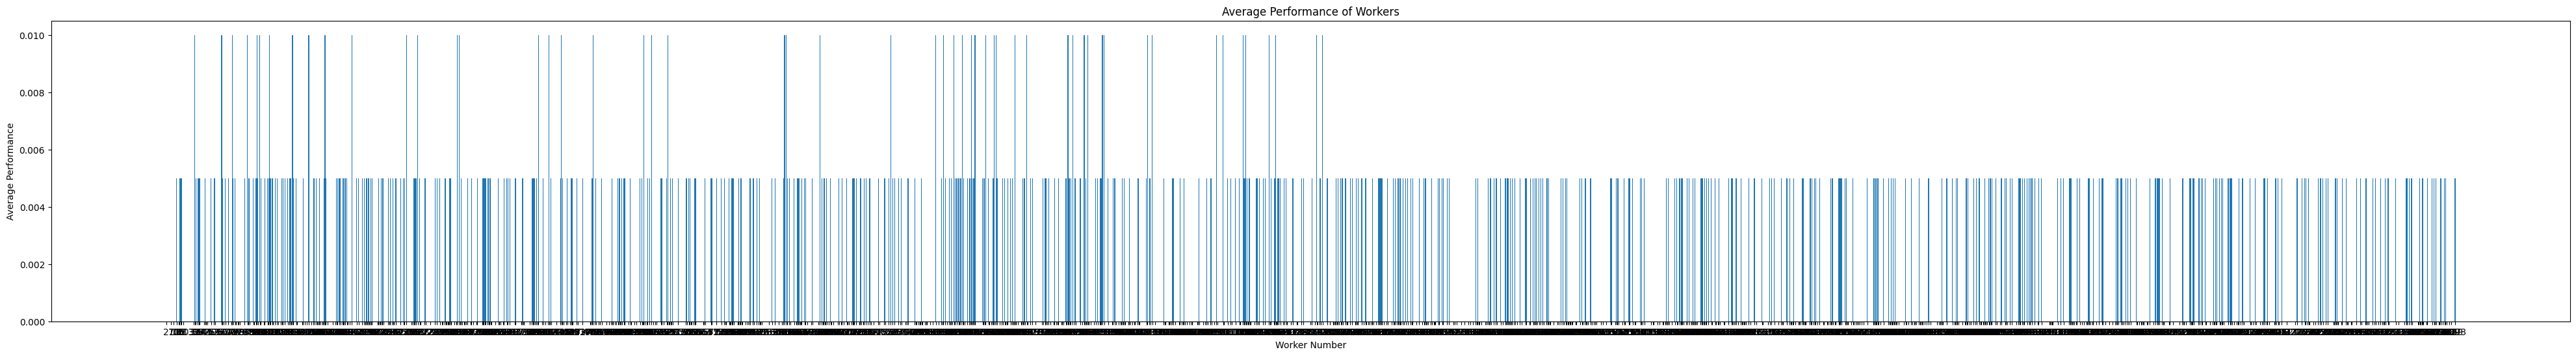

In [14]:
import matplotlib.pyplot as plt

# for i, histories in enumerate(worker_histories.values()):
print(worker_histories)

avg_performance = {worker: sum([perf for _, perf in history])/len(history) for worker, history in worker_histories.items()}

worker_numbers = [int(worker.split()[1]) for worker in avg_performance.keys()]

print(avg_performance)

plt.figure(figsize=(50, 6))
plt.bar(worker_numbers, list(avg_performance.values()), align='center')
plt.xticks(worker_numbers)
plt.ylabel('Average Performance')
plt.title('Average Performance of Workers')
plt.xlabel('Worker Number')
plt.show()